### Modelo Prediccion de Diabetes con XGBOOST

In [1]:
import numpy as np 
import pandas as pd 

In [3]:
df_train=pd.read_csv("/kaggle/input/playground-series-s6e2/train.csv")
df_test=pd.read_csv("/kaggle/input/playground-series-s6e2/test.csv")

In [4]:
df_train.shape,df_test.shape

((630000, 15), (270000, 14))

In [5]:
df_train.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14  Hear

In [7]:
for i in df_train.columns[1:]:
    print("variable: ", i)
    print(df_train[i].nunique())

variable:  Age
42
variable:  Sex
2
variable:  Chest pain type
4
variable:  BP
66
variable:  Cholesterol
150
variable:  FBS over 120
2
variable:  EKG results
3
variable:  Max HR
93
variable:  Exercise angina
2
variable:  ST depression
66
variable:  Slope of ST
3
variable:  Number of vessels fluro
4
variable:  Thallium
3
variable:  Heart Disease
2


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler, MaxAbsScaler,OneHotEncoder

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(["Heart Disease","id"],axis=1), df_train["Heart Disease"], test_size=0.2, random_state=101)

In [10]:
y_train=y_train.map({"Absence":0,"Presence":1})
y_test=y_test.map({"Absence":0,"Presence":1})

#### Importancia de Variables

In [11]:
from sklearn.feature_selection import mutual_info_classif

In [12]:
mi = mutual_info_classif(X_train, y_train)
mi_df = pd.DataFrame({"Feature": X_train.columns, "Mutual Information": mi})
mi_df = mi_df.sort_values(by="Mutual Information", ascending=False)
print(mi_df)


                    Feature  Mutual Information
12                 Thallium            0.226103
2           Chest pain type            0.180183
7                    Max HR            0.129277
11  Number of vessels fluro            0.119526
8           Exercise angina            0.118466
10              Slope of ST            0.118215
1                       Sex            0.117161
9             ST depression            0.107655
6               EKG results            0.065394
0                       Age            0.029066
4               Cholesterol            0.011479
3                        BP            0.007775
5              FBS over 120            0.001818


Se observa que la variable "Thallium" (variablecualitativa)  es lamas importante revisando los datos  contiene solo los valores [3,7,6].

<Axes: xlabel='Thallium', ylabel='count'>

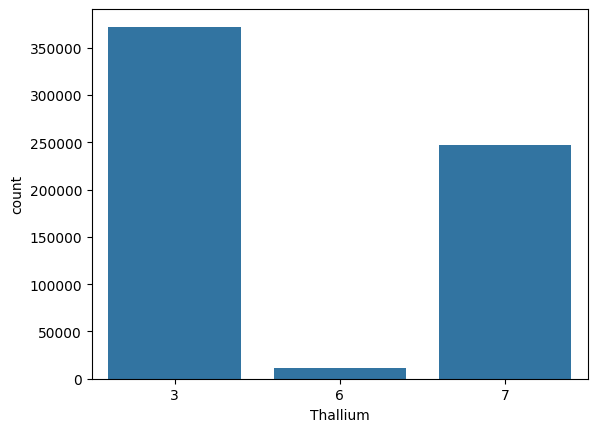

In [17]:
sns.countplot(data=df_train,x="Thallium")

<Axes: xlabel='Thallium', ylabel='count'>

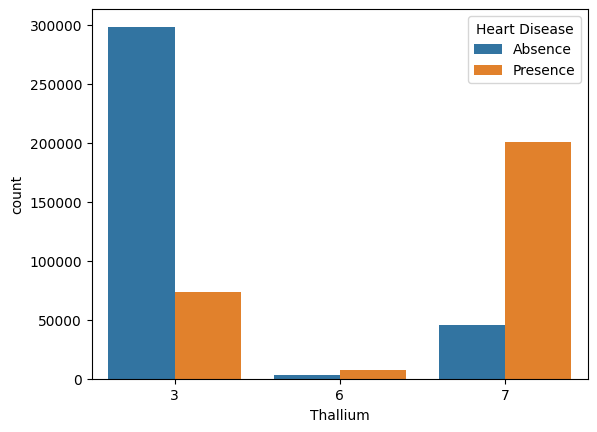

In [16]:
sns.countplot(data=df_train,x="Thallium",hue="Heart Disease")

Observamos que la distribucion de la variables target que es binario muestra diferencias en proporciones de las clases, siendo la categoria "7" con mayores valores positivos. Con la finalidad de ayudar al modelo se realizara un modelo para cada categoria y evaluaremos los resultados. 

In [18]:
var_cuanti=["Age","BP","Cholesterol","Max HR", "ST depression"]
target='Heart Disease'
#var_cat_2=["Slope of ST","EKG results","Chest pain type","Number of vessels fluro"]
var_corte="Thallium"
var_cat=[a for a in df_train.columns if a not in ["id",target,var_corte]+var_cuanti]
var_cat

['Sex',
 'Chest pain type',
 'FBS over 120',
 'EKG results',
 'Exercise angina',
 'Slope of ST',
 'Number of vessels fluro']

In [21]:
from sklearn.preprocessing import PolynomialFeatures

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [34]:
from collections import Counter

### Modelo XGBOOST 

In [ ]:
y_test_acum=[]
dict_model={}
for i in [3,7,6]:
    idx=X_train[var_corte]==i
    idx_t=X_test[var_corte]==i
    x_train1,y_train1=X_train.loc[idx],y_train.loc[idx]
    x_test1,y_test1=X_test.loc[idx_t],y_test.loc[idx_t]

    # Calcular proporción
   # counter = Counter(y_train1)
    #neg, pos = counter[0], counter[1]
    #ratio = neg / pos
    
    trans_num=Pipeline(steps=[
         ("poly",PolynomialFeatures(degree=2,interaction_only=True,
            include_bias=False)),
         ("scaler_robust",RobustScaler()),
         ])
    preprocessor = ColumnTransformer(
    transformers=[
              ('trans_num', trans_num, var_cuanti),
       # ("one",OneHotEncoder(handle_unknown='ignore',sparse_output=False),var_cat)
          ],remainder="passthrough")

    model0 = Pipeline(steps=[
              ('preprocessor', preprocessor),
       ("model",
                    XGBClassifier(
                    n_estimators=800,
                    max_depth=5,
                    learning_rate=0.03,
                   # scale_pos_weight=ratio,
                    subsample=0.7,
                    colsample_bytree=0.7,
                    random_state=42,
                    eval_metric="auc"))])
   
    model0.fit(x_train1,y_train1 )
    dict_model[i]=model0
    pred_test=model0.predict_proba(x_test1)[:,1]
    df_test_pred=pd.DataFrame(index=y_test1.index)
    df_test_pred["pred"]=pred_test
    y_test_acum.append(df_test_pred)
    del df_test_pred
    ### pred total ##
    
    print("Metodo",i)
    print("Ttest: Metrica AUC",roc_auc_score(y_test1,pred_test))

Metodo 3
Ttest: Metrica AUC 0.9211013661257087
Metodo 7
Ttest: Metrica AUC 0.9072674949994344
Metodo 6
Ttest: Metrica AUC 0.9037197789908183


In [24]:
dict_model[3]

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trans_num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('scaler_robust',
                                                                   RobustScaler())]),
                                                  ['Age', 'BP', 'Cholesterol',
                                                   'Max HR',
                                                   'ST depression'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsamp...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, ...))])

#### Resultado global:

In [44]:
roc_auc_score(y_test.sort_index(),pd.concat(y_test_acum,axis=0)["pred"].sort_index())

np.float64(0.9542286189914042)

In [28]:
pred_3=dict_model[3].predict_proba(df_test[df_test[var_corte]==3][X_train.columns])[:,1]
pred_6=dict_model[6].predict_proba(df_test[df_test[var_corte]==6][X_train.columns])[:,1]
pred_7=dict_model[7].predict_proba(df_test[df_test[var_corte]==7][X_train.columns])[:,1]

In [29]:
df_3=df_test[df_test[var_corte]==3][["id"]]
df_3[target]=pred_3

df_6=df_test[df_test[var_corte]==6][["id"]]
df_6[target]=pred_6

df_7=df_test[df_test[var_corte]==7][["id"]]
df_7[target]=pred_7


In [30]:
df_sub=pd.concat([df_3,df_6,df_7],axis=0).sort_values(["id"])

In [31]:
df_sub.to_csv("submision6.csv",index=None,header=True)